## Wesley Mitchell
### ViT/DETR Model Implementation

In [90]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

#### Load the Stitched MNIST Dataset

In [91]:
#function to load images
def load_images(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=1)
    img = float(img) / 255.0
    return img

#function to convert string to numbers
def string_to_numbers(label_str):
    return tf.strings.to_number(tf.strings.split(label_str, ', '), out_type=tf.int32)
    
        
#function to load the dataset with examples and labels
def load_dataset(images_dir, labels_path):
    img_file_paths = tf.data.Dataset.list_files(images_dir + '/*.png', shuffle=False)
    images_dataset = img_file_paths.map(LoadImages)
    
    labels_dataset = tf.data.TextLineDataset(labels_path)
    labels_dataset = labels_dataset.map(string_to_list)
    
    dataset = tf.data.Dataset.zip((images_dataset, labels_dataset))
    
    return images_dataset, labels_dataset

#load training set
train_images_dir = "../dataset/StitchedMNIST/train/examples"
train_labels_path = "../dataset/StitchedMNIST/train/labels.txt"
(x_train, y_train) = load_dataset(train_images_dir, train_labels_path)

#load validation set
valid_images_dir = "../dataset/StitchedMNIST/validation/examples"
valid_labels_path = "../dataset/StitchedMNIST/validation/labels.txt"
(x_valid, y_valid) = load_dataset(valid_images_dir, valid_labels_path)
    
    

/Users/wesleymitchell/anaconda3/envs/Tensorflow/lib/python3.10/site-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


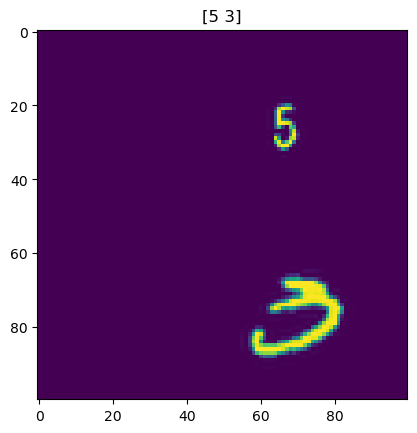

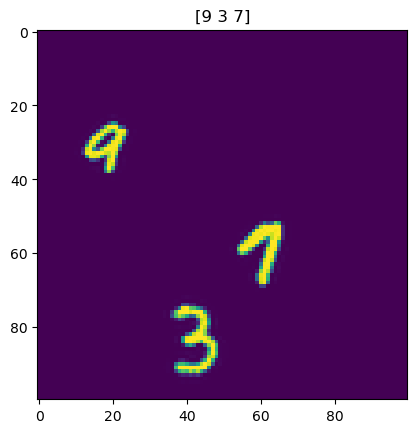

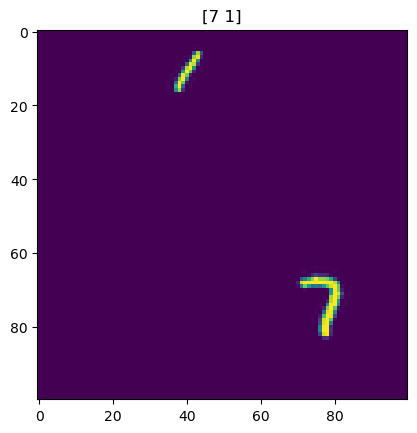

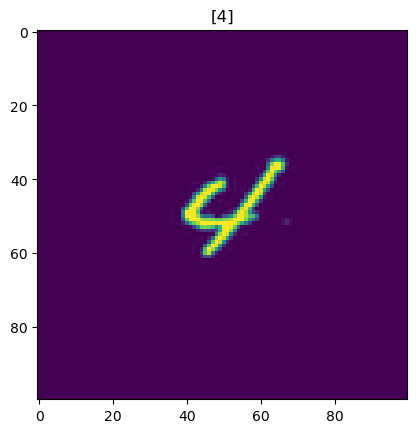

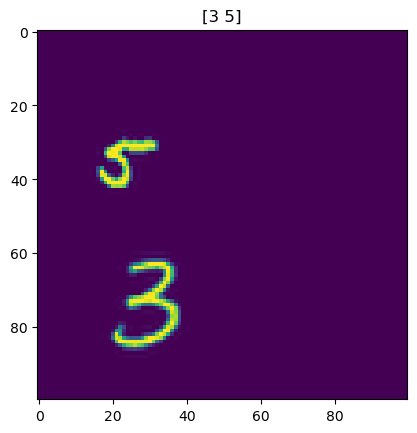

In [92]:
#plot examples to check if data was loaded correctly
train = tf.data.Dataset.zip((x_train, y_train))
for image, label in train.take(5):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy())
    plt.show()


#### Implement ViT Architecture
Based on the implementation found in the Karas documentation. [link](https://keras.io/examples/vision/image_classification_with_vision_transformer/)

In [93]:
#define the hyperparameters
learning_rate = 0.001
weight_decay = 0.0001
bath_size = 256
num_epochs = 100
image_size = 100
patch_size = 10
num_pathes = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
mlp_head_units = [2048, 1024]

In [94]:
#data augmentation
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
images_dataset = train_dataset.map(lambda image, label: image)
data_augmentation.layers[0].adapt(images_dataset)

In [95]:
#implement MLP
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [96]:
#create a layer for creating the patches
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 100 X 100
Patch size: 10 X 10
Patches per image: 100
Elements per patch: 100


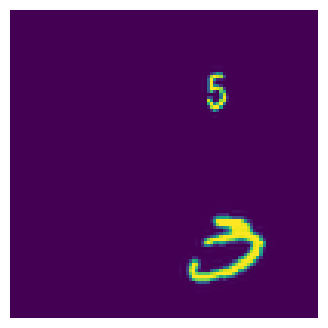

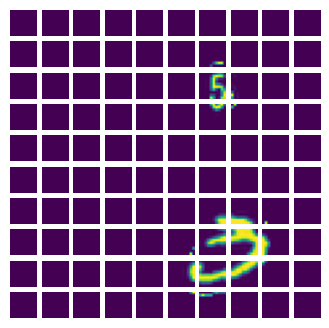

In [97]:
numpy_iterator = train.as_numpy_iterator()
plt.figure(figsize=(4, 4))
image, labels = next(numpy_iterator)

plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 1))
    plt.imshow(patch_img.numpy())
    plt.axis("off")